In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [4]:
S0 = np.array([0,0.586*149597870700])   # m
V0 = np.array([54600,0])                # m s^-1
Ms = 1.989e30                               # kg
G = 6.6741e-11                              # m^3 kg^-1 s^-2
year = 31556926                             # s

In [5]:
def s_1(s,v,dt):
    return s+v*dt

def v_1(v,r,s,dt):
    return v - G*Ms*s*dt/(r**3)

def r_1(s):

    return math.sqrt(s[0]**2 + s[1]**2)

def Euler(v0,s0,dt,years):
    t = int(year*years/dt)+1
    s = np.zeros([t,2])
    v = np.zeros([t,2])
    t = np.arange(0,years*year,dt)
    
    s[0] = s0
    v[0] = v0

    for i in range(1,len(s)):
        s[i] = s_1(
            s[i-1],
            v[i-1],
            dt)
        v[i] = v_1(
            v[i-1],
            r_1(s[i-1]),
            s[i-1],
            dt)
    return (s,v, t)

In [6]:

def k1(u):
    f1 = u[2]
    f2 = u[3]
    f3 = (-G*Ms/r_1(u[:2])**3)*u[0]
    f4 = (-G*Ms/r_1(u[:2])**3)*u[1]
    return np.array([f1,f2,f3,f4])

def k2(u,dt,K1):
    r = [u[0]+K1[0]*dt/2,u[1]+K1[1]*dt/2]
    f1 = u[2] + dt*K1[2]/2
    f2 = u[3] + dt*K1[3]/2
    f3 = (-G*Ms/r_1(r)**3)*(u[0]+K1[0]*dt/2)
    f4 = (-G*Ms/r_1(r)**3)*(u[1]+K1[1]*dt/2)
    return np.array([f1,f2,f3,f4])

def k3(u,dt,K2):
    r = [u[0]+K2[0]*dt/2,u[1]+K2[1]*dt/2]
    f1 = u[2] + K2[2]*dt/2
    f2 = u[3] + K2[3]*dt/2
    f3 = (-G*Ms/r_1(r)**3)*(u[0] + K2[0]*dt/2)
    f4 = (-G*Ms/r_1(r)**3)*(u[1] + K2[1]*dt/2)
    return np.array([f1,f2,f3,f4])

def k4(u,dt,K3):
    r = [u[0]+K3[0]*dt/2,u[1]+K3[1]*dt/2]
    f1 = u[2] + K3[2]*dt
    f2 = u[3] + K3[3]*dt
    f3 = (-G*Ms/r_1(u[:2])**3)*(u[0] + K3[0]*dt)
    f4 = (-G*Ms/r_1(u[:2])**3)*(u[1] + K3[1]*dt)
    return np.array([f1,f2,f3,f4])

def RK4(s0,v0,years,dt):
    t = int(year*years/dt)+1
    u = np.zeros([t,4])
    t = np.arange(0,years*year,dt)
    u[0] = np.append(s0,v0)
    for i in range(1,len(u)):
        K1 = k1(u[i-1])
        K2 = k2(u[i-1],dt, K1)
        K3 = k3(u[i-1],dt, K2)
        K4 = k4(u[i-1],dt, K3)
        u[i] = u[i-1] + dt*(K1 + 2*K2 + 2*K3 + K4)/6
    return (u, t)


In [10]:
def RK4_krok(s0,v0,years,dt,tol):
    temp = 1000000
    u = np.zeros([temp,4])
    t = np.zeros([temp])
    u[0] = np.append(s0,v0)
    t[0] = dt
    u_1 = 0
    i = 1
    time = 0
    while time < year*years:
        K1 = k1(u[i-1])
        K2 = k2(u[i-1],dt, K1)
        K3 = k3(u[i-1],dt, K2)
        K4 = k4(u[i-1],dt, K3)
        u[i] = u[i-1] + dt*(K1 + 2*K2 + 2*K3 + K4)/6

        K1 = k1(u[i-1])
        K2 = k2(u[i-1],dt/2, K1)
        K3 = k3(u[i-1],dt/2, K2)
        K4 = k4(u[i-1],dt/2, K3)
        u_1 = u[i-1] + dt*(K1 + 2*K2 + 2*K3 + K4)/12

        K1 = k1(u_1)
        K2 = k2(u_1,dt/2, K1)
        K3 = k3(u_1,dt/2, K2)
        K4 = k4(u_1,dt/2, K3)
        u_2 = u_1 + dt*(K1 + 2*K2 + 2*K3 + K4)/12

        e_1 = (u_2[0] - u[i][0])/(2**4 - 1)
        e_2 = (u_2[1] - u[i][1])/(2**4 - 1)
        e = e_2 if e_2 > e_1 else e_1
        
        if abs(e)<=tol:
            u[i] = u_2
            dt = 0.9*dt*((tol/abs(e))**(1/5))
        else:
            dt = 0.9*dt*((tol/abs(e))**(1/5))
            continue

        i += 1
        time += dt
        t[i] = t[i-1] + abs(dt)

    return (u, t)

def Euler_krok(v0,s0,dt,years,tol):
    
    temp = 10000000
    s = np.zeros([temp,2])
    v = np.zeros([temp,2])
    t = np.zeros([temp])

    t[0] = dt
    v[0] = v0
    s[0] = s0
    
    i = 1
    time = 0

    while time < year*years:
        
        s[i] = s_1(s[i-1], v[i-1], dt)
        v[i] = v_1(v[i-1], r_1(s[i-1]), s[i-1], dt)

        s_temp = s_1(s[i-1], v[i-1], dt/2)
        v_temp = v_1(v[i-1], r_1(s[i-1]), s[i-1], dt/2)

        s_temp2 = s_1(s_temp, v_temp, dt/2)
        v_temp2 = v_1(v_temp, r_1(s_temp), s_temp, dt/2)

        e_1 = abs(s_temp2[0] - s[i][0])
        e_2 = abs(s_temp2[1] - s[i][1])
        e = e_2 if e_2 > e_1 else e_1
        
        if e<=tol:
            s[i] = s_temp2
            v[i] = v_temp2
            dt = 0.9*dt*((tol/abs(e))**(1/2))
            i += 1
            time += dt
            t[i] = time
        else:
            dt = 0.9*dt*((tol/abs(e))**(1/2))
            continue



    return s, v, t

In [27]:
s, v, t = Euler(V0,S0,2000,200)

Text(0.5, 0.98, 'Euler')

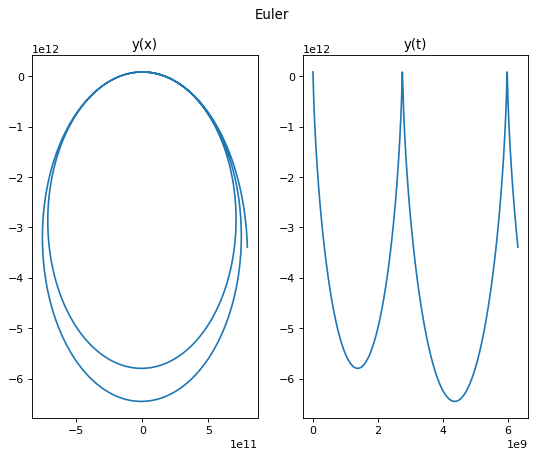

In [28]:
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(1,2,1)
plt.title('y(x)')
plt.plot(s.T[0],s.T[1])
plt.subplot(1,2,2)
plt.title('y(t)')
plt.plot(t,s.T[1])
fig.suptitle('Euler')


In [29]:
u , t = RK4(S0,V0,200,2000)

Text(0.5, 0.98, 'RK4')

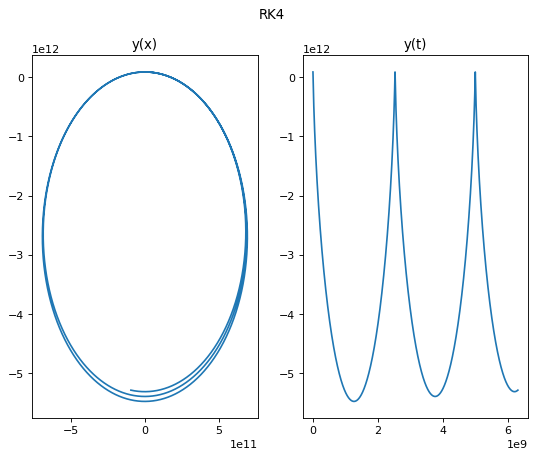

In [30]:
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(1,2,1)
plt.title('y(x)')
plt.plot(u.T[0],u.T[1])
plt.subplot(1,2,2)
plt.title('y(t)')
plt.plot(t,u.T[1])
fig.suptitle('RK4')

In [18]:
tol = 1000
u_1000 , t_1000 = RK4_krok(S0,V0,200,2000,tol)

tol = 100
u_100 , t_100 = RK4_krok(S0,V0,200,2000,tol)

tol = 10
u_10 , t_10 = RK4_krok(S0,V0,200,2000,tol)

tol = 5
u_5 , t_5 = RK4_krok(S0,V0,200,2000,tol)


In [19]:
u_5 = np.ma.masked_equal(u_5,0)
t_5 = np.ma.masked_equal(t_5,0)
u_5.compressed()
t_5.compressed()

u_10 = np.ma.masked_equal(u_10,0)
t_10 = np.ma.masked_equal(t_10,0)
u_10.compressed()
t_10.compressed()

u_100 = np.ma.masked_equal(u_100,0)
t_100 = np.ma.masked_equal(t_100,0)
u_100.compressed()
t_100.compressed()

u_1000 = np.ma.masked_equal(u_1000,0)
t_1000 = np.ma.masked_equal(t_1000,0)
u_1000.compressed()
t_1000.compressed()


array([2.00000000e+03, 2.04640487e+05, 4.11664146e+05, ...,
       6.30987621e+09, 6.31066532e+09, 6.31145924e+09])

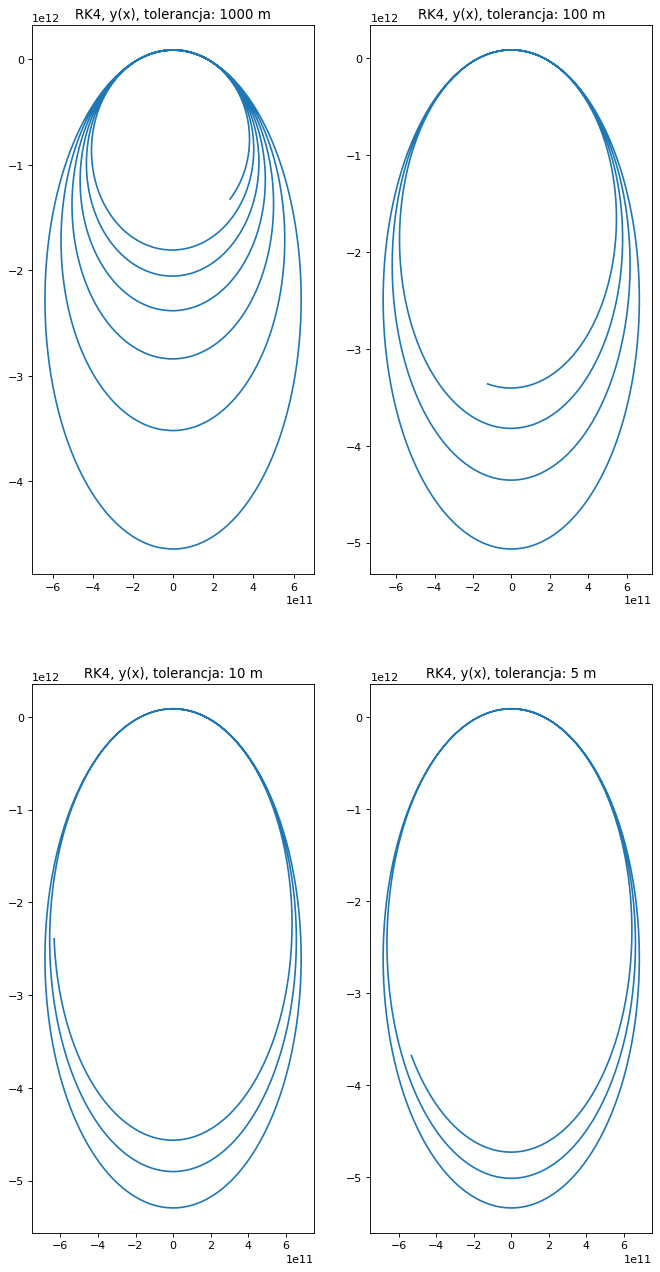

In [33]:
fig = plt.figure(figsize=(10, 20), dpi=80)
plt.subplot(2,2,1)
plt.title('RK4, y(x), tolerancja: 1000 m')
plt.plot(u_1000.T[0],u_1000.T[1])

plt.subplot(2,2,2)
plt.title('RK4, y(x), tolerancja: 100 m')
plt.plot(u_100.T[0],u_100.T[1])

plt.subplot(2,2,3)
plt.title('RK4, y(x), tolerancja: 10 m')
plt.plot(u_10.T[0],u_10.T[1])

plt.subplot(2,2,4)
plt.title('RK4, y(x), tolerancja: 5 m')
plt.plot(u_5.T[0],u_5.T[1])

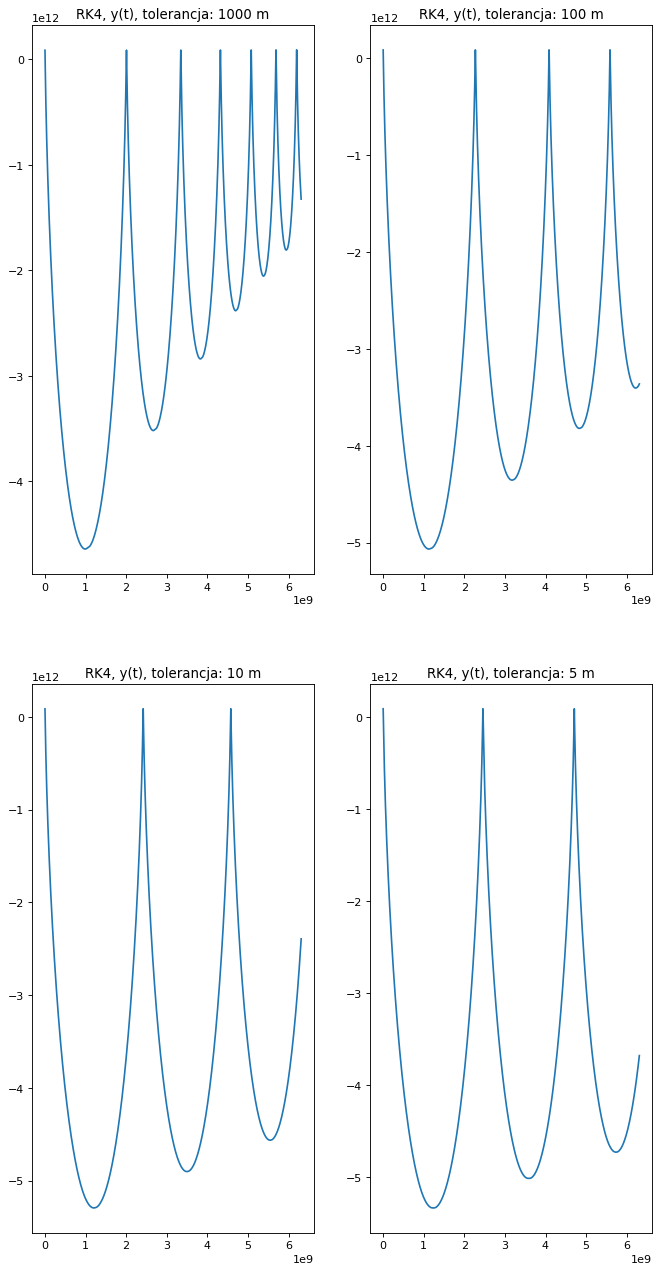

In [24]:
plt.figure(figsize=(10, 20), dpi=80)
plt.subplot(2,2,1)
plt.title('RK4, y(t), tolerancja: 1000 m')
plt.plot(t_1000,u_1000.T[1])

plt.subplot(2,2,2)
plt.title('RK4, y(t), tolerancja: 100 m')
plt.plot(t_100,u_100.T[1])

plt.subplot(2,2,3)
plt.title('RK4, y(t), tolerancja: 10 m')
plt.plot(t_10,u_10.T[1])

plt.subplot(2,2,4)
plt.title('RK4, y(t), tolerancja: 5 m')
plt.plot(t_5.compressed(),u_5.T[1].compressed())


In [23]:
tol = 1000
s_1000, v_1000 ,te_1000 = Euler_krok(V0,S0,2000,200,tol)

tol = 100
s_100, v_100 ,te_100 = Euler_krok(V0,S0,2000,200,tol)

tol = 10
s_10, v_10 ,te_10 = Euler_krok(V0,S0,2000,200,tol)

tol = 5
s_5, v_5 ,te_5 = Euler_krok(V0,S0,2000,200,tol)


In [35]:
s_1000 = np.ma.masked_equal(s_1000,0)
s_100 = np.ma.masked_equal(s_100,0)
s_10 = np.ma.masked_equal(s_10,0)
s_5 = np.ma.masked_equal(s_5,0)
s_1000.compressed()
s_100.compressed()
s_10.compressed()
s_5.compressed()

v_1000 = np.ma.masked_equal(v_1000,0)
v_100 = np.ma.masked_equal(v_100,0)
v_10 = np.ma.masked_equal(v_10,0)
v_5 = np.ma.masked_equal(v_5,0)
v_1000.compressed()
v_100.compressed()
v_10.compressed()
v_5.compressed()

te_1000 = np.ma.masked_equal(te_1000,0)
te_100 = np.ma.masked_equal(te_100,0)
te_10 = np.ma.masked_equal(te_10,0)
te_5 = np.ma.masked_equal(te_5,0)
te_1000.compressed()
te_100.compressed()
te_10.compressed()
te_5.compressed()


array([2.00000000e+03, 3.06243321e+01, 6.12487103e+01, ...,
       6.31138324e+09, 6.31138516e+09, 6.31138709e+09])

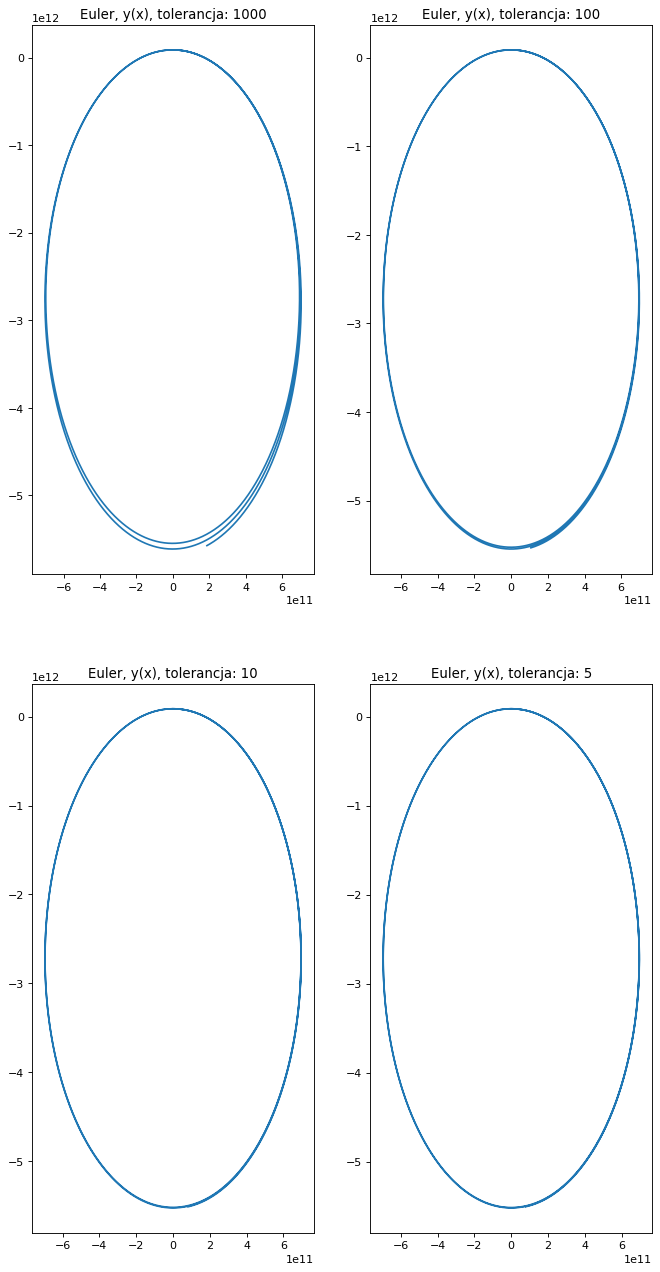

In [36]:
plt.figure(figsize=(10, 20), dpi=80)
plt.subplot(2,2,1)
plt.title('Euler, y(x), tolerancja: 1000')
plt.plot(s_1000.T[0],s_1000.T[1])

plt.subplot(2,2,2)
plt.title('Euler, y(x), tolerancja: 100')
plt.plot(s_100.T[0],s_100.T[1])

plt.subplot(2,2,3)
plt.title('Euler, y(x), tolerancja: 10')
plt.plot(s_10.T[0],s_10.T[1])

plt.subplot(2,2,4)
plt.title('Euler, y(x), tolerancja: 5')
plt.plot(s_5.T[0],s_5.T[1])

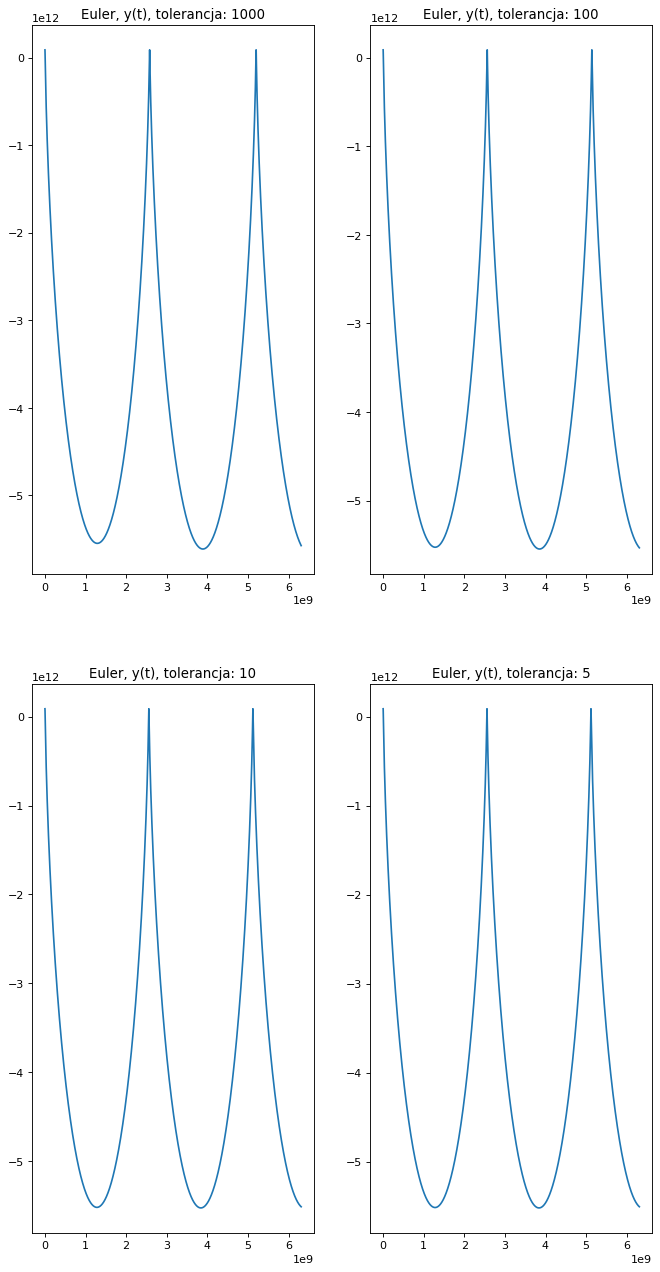

In [39]:
plt.figure(figsize=(10, 20), dpi=80)

plt.subplot(2,2,1)
plt.title('Euler, y(t), tolerancja: 1000')
plt.plot(te_1000,s_1000.T[1])

plt.subplot(2,2,2)
plt.title('Euler, y(t), tolerancja: 100')
plt.plot(te_100,s_100.T[1])

plt.subplot(2,2,3)
plt.title('Euler, y(t), tolerancja: 10')
plt.plot(te_10,s_10.T[1])

plt.subplot(2,2,4)
plt.title('Euler, y(t), tolerancja: 5')
plt.plot(te_5,s_5.T[1])